In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Importation des données

In [279]:
data_path = "../data/welddb.data"
column_names = [
    'C', 'Si', 'Mn', 'S', 'P', 'Ni', 'Cr', 'Mo', 'V', 'Cu', 'Co', 'W', 
    'O', 'Ti', 'N', 'Al', 'B', 'Nb', 'Sn', 'As', 'Sb', 
    'Current', 'Voltage', 'AC_DC', 'Electrode_polarity', 'Heat_input', 'Interpass_temp',  
    'Weld_type', 'PWHT_temp', 'PWHT_time', 
    'Yield_strength', 'UTS', 'Elongation', 'Reduction_area',  
    'Charpy_temp', 'Charpy_impact', 'Hardness', 'FATT_50', 
    'Primary_ferrite', 'Ferrite_2nd_phase', 'Acicular_ferrite', 'Martensite', 'Ferrite_carbide', 
    'Weld_ID' 
]
df = pd.read_csv(data_path, sep='\s+', names=column_names, na_values='N') # as the NaN values are represented by 'N' in the data file
df

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
C:\Users\quent\AppData\Local\Temp\ipykernel_41124\3830166299.py:12: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(data_path, sep='\s+', names=column_names, na_values='N') # as the NaN values are represented by 'N' in the data file


,C,Si,Mn,S,P,Ni,Cr,Mo,V,Cu,...,Charpy_temp,Charpy_impact,Hardness,FATT_50,Primary_ferrite,Ferrite_2nd_phase,Acicular_ferrite,Martensite,Ferrite_carbide,Weld_ID
0,0.037,0.30,0.65,0.008,0.012,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Aaw
1,0.037,0.30,0.65,0.008,0.012,0.00,NaN,NaN,NaN,NaN,...,-28.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Aawch
2,0.037,0.30,0.65,0.008,0.012,0.00,NaN,NaN,NaN,NaN,...,-38.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Aht
3,0.037,0.31,1.03,0.007,0.014,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Baw
4,0.037,0.31,1.03,0.007,0.014,0.00,NaN,NaN,NaN,NaN,...,-48.0,100.0,NaN,NaN,32,28.0,40.0,0.0,0.0,Evans-Ni/CMn-1990/1991-0Bawch
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647,0.100,0.35,0.90,0.008,0.016,0.60,8.6,0.98,0.18,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Birmingham-MAX35
1648,0.088,0.36,0.88,0.008,0.017,0.57,8.4,0.94,0.19,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Birmingham-MAX36
1649,0.090,0.34,0.89,0.008,0.016,0.17,8.2,0.94,0.02,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Birmingham-MAX37
1650,0.092,0.35,0.90,0.008,0.016,0.54,8.4,0.97,0.17,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Birmingham-MAX38


In [280]:
categorical_cols = ['AC_DC', 'Electrode_polarity', 'Weld_type', 'Weld_ID']
chemical_cols = ['C','Si','Mn','S','P','Ni','Cr','Mo','V','Cu','Co',
                 'W','O','Ti','N','Al','B','Nb','Sn','As','Sb']

# Data statistics

In [281]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 44 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   C                   1652 non-null   float64
 1   Si                  1652 non-null   float64
 2   Mn                  1652 non-null   float64
 3   S                   1648 non-null   object 
 4   P                   1642 non-null   float64
 5   Ni                  697 non-null    float64
 6   Cr                  784 non-null    float64
 7   Mo                  793 non-null    object 
 8   V                   928 non-null    object 
 9   Cu                  578 non-null    object 
 10  Co                  129 non-null    object 
 11  W                   75 non-null     object 
 12  O                   1256 non-null   float64
 13  Ti                  935 non-null    object 
 14  N                   1242 non-null   object 
 15  Al                  905 non-null    object 
 16  B     

On remarque que beaucoup de colonnes ont une majorité de valeurs manquantes. 

In [282]:
print(f"Proportion of missing values: {df.isna().sum().sum() / df.size}")

Proportion of missing values: 0.45593495487563285


Text(0, 0.5, 'Proportion of missing values')

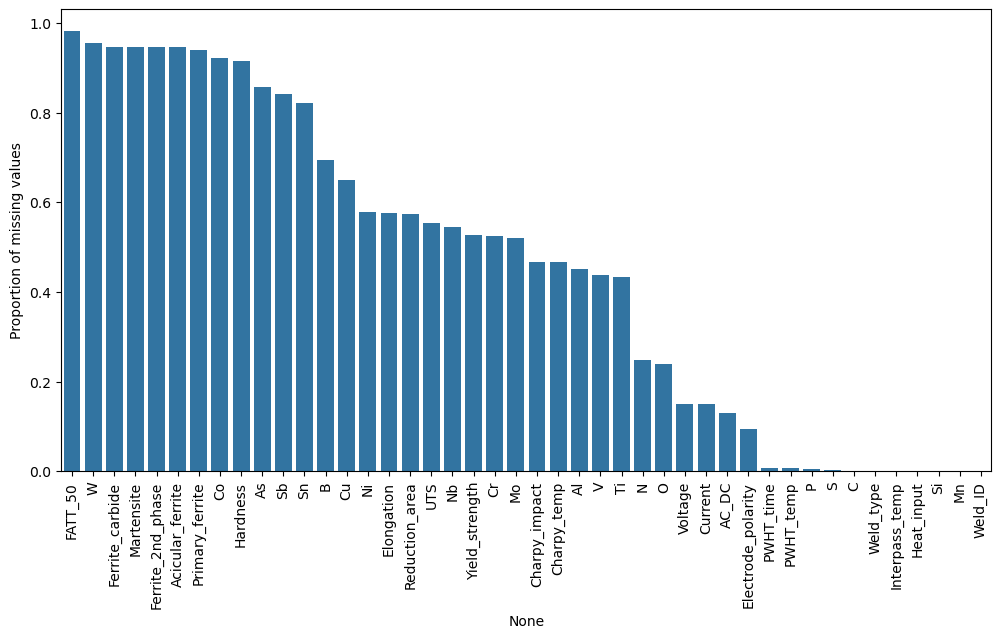

In [283]:
df_missing = df.isna().sum().sort_values(ascending=False) / len(df)
plt.figure(figsize=(12,6))
sns.barplot(x=df_missing.index, y=df_missing.values)
plt.xticks(rotation=90)
plt.ylabel('Proportion of missing values')

Text(0, 0.5, 'Proportion of missing values')

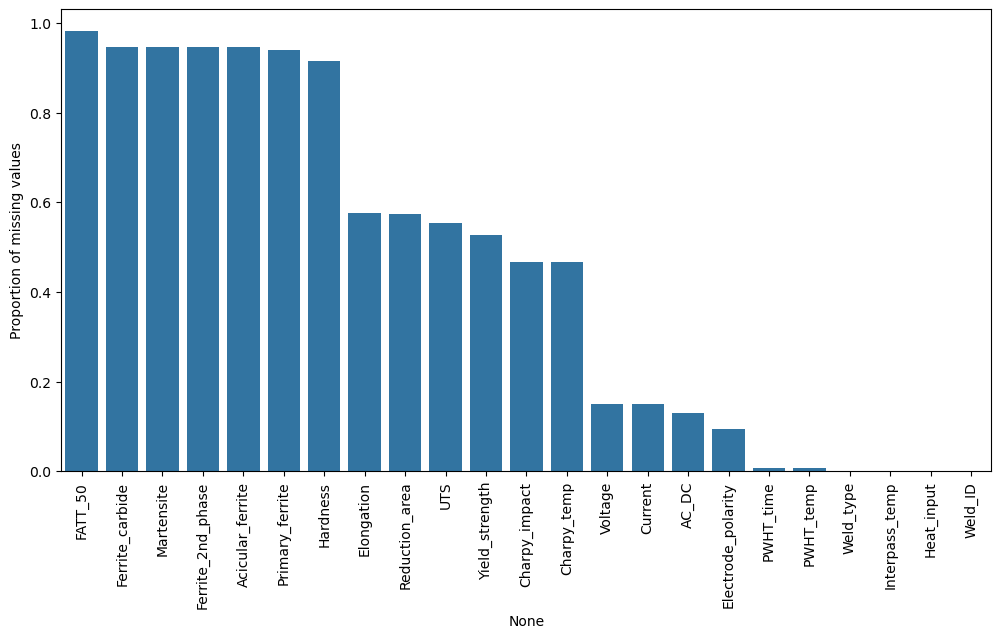

In [284]:
df_missing_non_chemical = df_missing.drop(chemical_cols)
plt.figure(figsize=(12,6))
sns.barplot(x=df_missing_non_chemical.index, y=df_missing_non_chemical.values)
plt.xticks(rotation=90)
plt.ylabel('Proportion of missing values')

In [285]:
df_missing_non_chemical * len(df)

FATT_50               1621.0
Ferrite_carbide       1563.0
Martensite            1563.0
Ferrite_2nd_phase     1562.0
Acicular_ferrite      1562.0
Primary_ferrite       1554.0
Hardness              1514.0
Elongation             952.0
Reduction_area         947.0
UTS                    914.0
Yield_strength         872.0
Charpy_impact          773.0
Charpy_temp            773.0
Voltage                248.0
Current                248.0
AC_DC                  215.0
Electrode_polarity     156.0
PWHT_time               13.0
PWHT_temp               13.0
Weld_type                0.0
Interpass_temp           0.0
Heat_input               0.0
Weld_ID                  0.0
dtype: float64

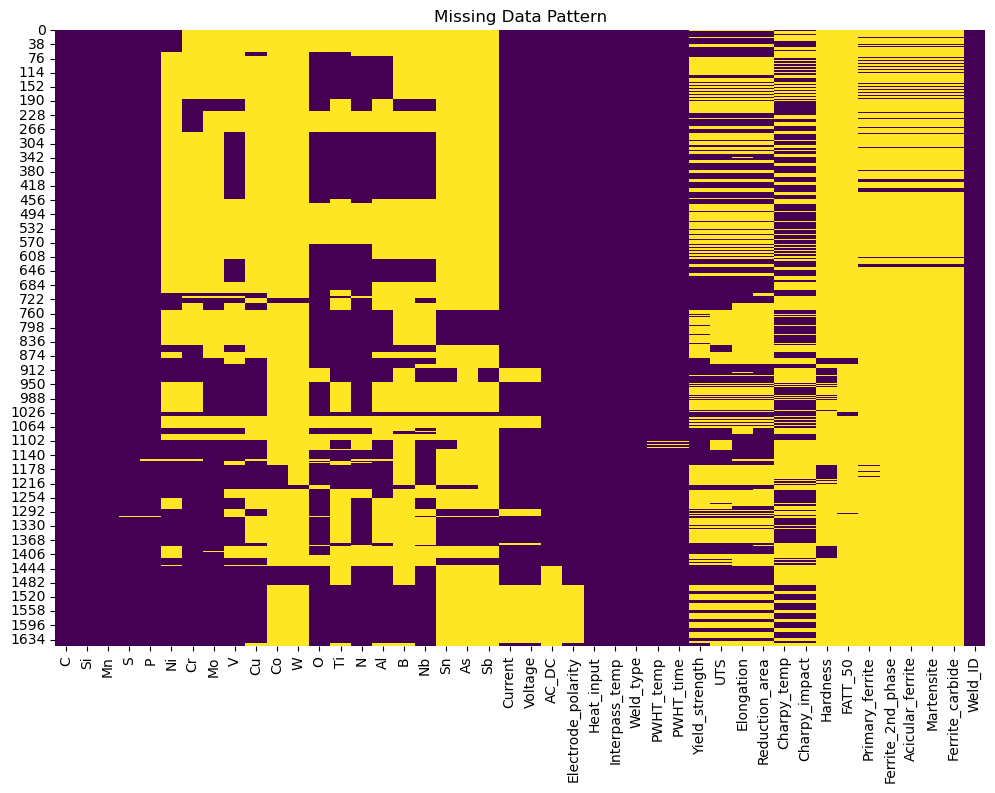

In [286]:
# Visualize missing data pattern
plt.figure(figsize=(12,8))
sns.heatmap(df.isna(), cbar=False, cmap='viridis')
plt.title('Missing Data Pattern')
plt.show()

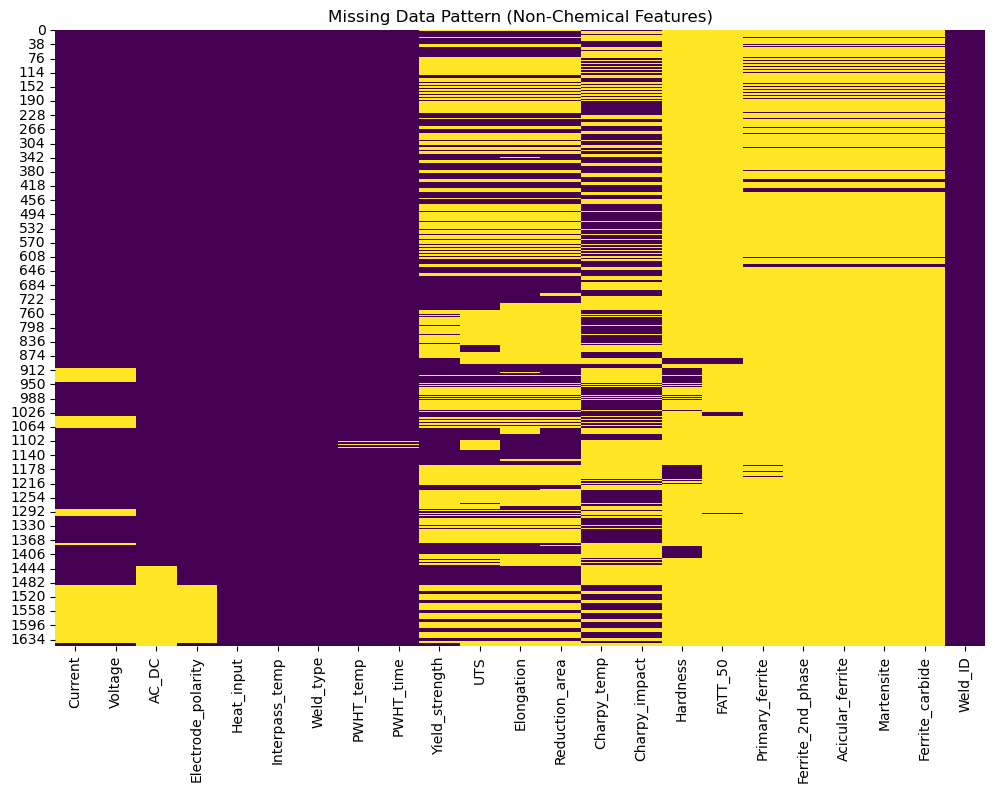

In [287]:
# visualize for non-chemical features only
plt.figure(figsize=(12,8))
sns.heatmap(df.drop(columns=chemical_cols).isna(), cbar=False, cmap='viridis')
plt.title('Missing Data Pattern (Non-Chemical Features)')
plt.show()

On a des colonnes qui ont l'air d'être toujours présentes ensemble et d'autres alors que les autres sont absentes. Comme si l'on avait fusionner des datasets différents sur des colonnes en commun. 

Les colonnes communes seraient les colonnes des éléments chimiques, et les colonnes : ["Current", "Voltage", "AC_DC", "Electrode_polarity", "Heat_input", "Interpass_temp", "Weld_type", "PWHT_temp", "PWHT_time"].

Les colonnes du premier dataset : ["Yield_strength", "UTS", "Elongation", "Reduction_area"]

Deuxième : ["Charpy_temp", "Charpy_impact"]

Troisième : ["Primary_ferrite", "Ferrite_2nd_phase", "Acicular_ferrite", "Martensite", "Ferrite_carbide"]

Hardness et FATT_50 ont l'air seuls. 

In [288]:
common_columns = chemical_cols + ["Current", "Voltage", "AC_DC", "Electrode_polarity", "Heat_input", "Interpass_temp", "Weld_type", "PWHT_temp", "PWHT_time"]
first_dataset_cols = ["Yield_strength", "UTS", "Elongation", "Reduction_area"]
second_dataset_cols = ["Charpy_temp", "Charpy_impact"]
third_dataset_cols = ["Primary_ferrite", "Ferrite_2nd_phase", "Acicular_ferrite", "Martensite", "Ferrite_carbide"]

df_first = df[common_columns + first_dataset_cols]
df_second = df[common_columns + second_dataset_cols]
df_third = df[common_columns + third_dataset_cols]

In [289]:
idx_1 = set(list(df_first.dropna(subset=first_dataset_cols, how='all').index))
idx_2 = set(list(df_second.dropna(subset=second_dataset_cols, how='all').index))
idx_3 = set(list(df_third.dropna(subset=third_dataset_cols, how='all').index))

print(f"intersection of all three datasets: {idx_1 & idx_2 & idx_3}")
print(f"intersection of first and second datasets: {idx_1 & idx_2}")
print(f"intersection of first and third datasets: {idx_1 & idx_3}")
print(f"intersection of second and third datasets: {idx_2 & idx_3}")

intersection of all three datasets: set()
intersection of first and second datasets: {1024, 1025, 2, 1026, 1027, 5, 1028, 1029, 8, 1030, 1031, 11, 1032, 1033, 1034, 1035, 24, 27, 30, 33, 36, 39, 42, 48, 51, 54, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 617, 620, 623, 626, 629, 632, 635, 638, 641, 644, 647, 650, 653, 656, 659, 662, 665, 668, 671, 674, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 217, 220, 223, 226, 239, 242, 245, 248, 251, 254, 257, 260, 263, 266, 269, 335, 338, 341, 344, 347, 350, 353, 356, 359, 362, 365, 368, 371, 374, 377, 380, 383, 895, 896, 386, 897, 898, 389, 899, 900, 901, 902, 903, 395, 904, 905, 398, 906, 401, 404, 407, 410, 413, 416, 419, 422, 425, 428, 431, 434, 437, 440, 443, 446, 449, 452}
intersection of first and third datasets: set()
intersection of second and third datasets: {640, 643, 4, 261, 10, 267, 394, 397, 270, 400, 403, 406, 26, 32, 38, 424, 427, 44, 430, 433

In [290]:
print(f"Number of samples in intersection of first and second datasets: {len(idx_1 & idx_2)}")
print(f"Number of samples in intersection of first and third datasets: {len(idx_1 & idx_3)}")
print(f"Number of samples in intersection of second and third datasets: {len(idx_2 & idx_3)}")
print("\n"+"_"*90+"\n")
print(f"Part de valeurs du dataset 2 présentes dans le dataset 1: {len(idx_1 & idx_2)/len(idx_1):.2%}")
print(f"Part de valeurs du dataset 1 présentes dans le dataset 2: {len(idx_1 & idx_2)/len(idx_2):.2%}")
print(f"Part de valeurs du dataset 3 présentes dans le dataset 1: {len(idx_1 & idx_3)/len(idx_1):.2%}")
print(f"Part de valeurs du dataset 1 présentes dans le dataset 3: {len(idx_1 & idx_3)/len(idx_3):.2%}")
print(f"Part de valeurs du dataset 3 présentes dans le dataset 2: {len(idx_2 & idx_3)/len(idx_2):.2%}")
print(f"Part de valeurs du dataset 2 présentes dans le dataset 3: {len(idx_2 & idx_3)/len(idx_3):.2%}")

Number of samples in intersection of first and second datasets: 144
Number of samples in intersection of first and third datasets: 0
Number of samples in intersection of second and third datasets: 46

__________________________________________________________________________________________

Part de valeurs du dataset 2 présentes dans le dataset 1: 17.73%
Part de valeurs du dataset 1 présentes dans le dataset 2: 16.38%
Part de valeurs du dataset 3 présentes dans le dataset 1: 0.00%
Part de valeurs du dataset 1 présentes dans le dataset 3: 0.00%
Part de valeurs du dataset 3 présentes dans le dataset 2: 5.23%
Part de valeurs du dataset 2 présentes dans le dataset 3: 46.94%


In [291]:
len(idx_1), len(idx_2), len(idx_3)

(812, 879, 98)

Le dataset 1 et 3 sont complètements indépendants. Le dataset 2 n'a presque pas de valeurs en commun avec le dataset 3, on les considère indépendant aussi. Le dataset 3 n'a que très peu de valeur (98) et est à moitié composé du dataset 2. Pour essayer de faire de l'imputing on a trop peu de valeurs, on drop ces colonnes. 

Le dataset 1 et 2 ont respectivement 17.73% et 16.38% de valeurs communes et composent chacun environ la moitié du dataset. On va pouvoir utiliser ces deux datasets.  

In [292]:
(df['Hardness'].isna() == False).sum(), (df['FATT_50'].isna() == False).sum()

(138, 31)

Hardness et FATT_50 ont toutes 2 trop peu de valeurs, on va les drop. 

# Gestion des colonnes communes 

In [293]:
df_common = df[common_columns]
df_common

,C,Si,Mn,S,P,Ni,Cr,Mo,V,Cu,...,Sb,Current,Voltage,AC_DC,Electrode_polarity,Heat_input,Interpass_temp,Weld_type,PWHT_temp,PWHT_time
0,0.037,0.30,0.65,0.008,0.012,0.00,NaN,NaN,NaN,NaN,...,NaN,170.0,21.0,DC,+,1.0,200,MMA,250.0,14.0
1,0.037,0.30,0.65,0.008,0.012,0.00,NaN,NaN,NaN,NaN,...,NaN,170.0,21.0,DC,+,1.0,200,MMA,0.0,0.0
2,0.037,0.30,0.65,0.008,0.012,0.00,NaN,NaN,NaN,NaN,...,NaN,170.0,21.0,DC,+,1.0,200,MMA,580.0,2.0
3,0.037,0.31,1.03,0.007,0.014,0.00,NaN,NaN,NaN,NaN,...,NaN,170.0,21.0,DC,+,1.0,200,MMA,250.0,14.0
4,0.037,0.31,1.03,0.007,0.014,0.00,NaN,NaN,NaN,NaN,...,NaN,170.0,21.0,DC,+,1.0,200,MMA,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647,0.100,0.35,0.90,0.008,0.016,0.60,8.6,0.98,0.18,NaN,...,NaN,450.0,30.0,NaN,+,2.0,200,SA,760.0,2.0
1648,0.088,0.36,0.88,0.008,0.017,0.57,8.4,0.94,0.19,NaN,...,NaN,450.0,30.0,NaN,+,2.0,200,SA,760.0,2.0
1649,0.090,0.34,0.89,0.008,0.016,0.17,8.2,0.94,0.02,NaN,...,NaN,450.0,30.0,NaN,+,2.0,200,SA,760.0,2.0
1650,0.092,0.35,0.90,0.008,0.016,0.54,8.4,0.97,0.17,NaN,...,NaN,450.0,30.0,NaN,+,2.0,200,SA,760.0,2.0


In [294]:
non_numeric_cols = []
for dtype in df_common.dtypes.unique():
    if dtype == 'object':
        non_numeric_cols.extend(df_common.columns[df_common.dtypes == dtype].tolist())
non_numeric_cols


['S',
 'Mo',
 'V',
 'Cu',
 'Co',
 'W',
 'Ti',
 'N',
 'Al',
 'B',
 'Nb',
 'Sn',
 'As',
 'Sb',
 'AC_DC',
 'Electrode_polarity',
 'Interpass_temp',
 'Weld_type']

## Gestion des colonnes chimiques non-numériques

In [295]:
non_num_chemical_cols = ['S','Mo','V','Cu','Co','W','Ti','N','Al','B','Nb','Sn','As','Sb']

# Lorsque nan on remplace par 0 pour les colonnes chimiques 
df_common.fillna({col: 0 for col in chemical_cols}, inplace=True)

C:\Users\quent\AppData\Local\Temp\ipykernel_41124\3944992784.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_common.fillna({col: 0 for col in chemical_cols}, inplace=True)


In [296]:
# On regarde les valeurs uniques pour chaque colonne chimique non-numérique

non_num_vals = {}
for col in non_num_chemical_cols:
    unique_val_col = df_common[col].dropna().unique()
    for val in unique_val_col:
        try:
            float(val)
        except:
            non_num_vals[col] = non_num_vals.get(col, []) + [val]
non_num_vals

{'S': ['<0.002'],
 'Mo': ['<0.01'],
 'V': ['<0.0005', '<0.01', '<0.005', '<5'],
 'Cu': ['<0.01'],
 'Co': ['<0.01'],
 'W': ['<0.1'],
 'Ti': ['<5', '<100', '<0.01', '<10'],
 'N': ['67tot33res',
  '66totndres',
  '61tot34res',
  '54totndres',
  '54tot24res',
  '52tot18res',
  '50tot17res',
  '48tot18res'],
 'Al': ['<5', '<50', '<100', '<0.01'],
 'B': ['<5', '<10'],
 'Nb': ['<5', '<6', '<100', '<50'],
 'Sn': ['<100', '<10'],
 'As': ['<100'],
 'Sb': ['<100', '<10']}

In [297]:
for col in non_num_chemical_cols:
    tmp = df[col].astype(float, errors='ignore')
    tmp.replace(non_num_vals.get(col, []), np.nan, inplace=True)
    tmp.dropna(inplace=True)
    tmp = tmp.astype(float)
    tmp = tmp.describe()
    print(f"{col}:\n{tmp}\n")

S:
count    1641.000000
mean        0.009561
std         0.011239
min         0.001000
25%         0.006000
50%         0.007000
75%         0.010000
max         0.140000
Name: S, dtype: float64

Mo:
count    791.000000
mean       0.480358
std        0.477423
min        0.000000
25%        0.000000
50%        0.340000
75%        1.010000
max        1.500000
Name: Mo, dtype: float64

V:
count    620.000000
mean       0.072443
std        0.096364
min        0.000000
25%        0.004000
50%        0.015000
75%        0.180000
max        0.320000
Name: V, dtype: float64

Cu:
count    564.000000
mean       0.176188
std        0.325897
min        0.000000
25%        0.000000
50%        0.030000
75%        0.190000
max        1.630000
Name: Cu, dtype: float64

Co:
count    108.000000
mean       0.082889
std        0.385763
min        0.000000
25%        0.000000
50%        0.000000
75%        0.010000
max        2.800000
Name: Co, dtype: float64

W:
count    63.000000
mean      0.140794
std  

Les unités sont différentes entre les colonnes. On va normaliser après avoir remplacer les valeurs. Pour la colonne 'N' on peut prendre le premier nombre qui a l'air d'être le total (tot). 

In [298]:
df_common.loc[:, 'N'] = df_common['N'].apply(lambda x: float(str(x).split('tot')[0]) if 'tot' in str(x) else x).astype(float)
df_common["N"] = df_common["N"].astype(float)
df_common["N"].describe()

C:\Users\quent\AppData\Local\Temp\ipykernel_41124\3175302577.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_common["N"] = df_common["N"].astype(float)


count    1652.000000
mean       83.233051
std        94.774594
min         0.000000
25%        21.000000
50%        74.000000
75%        94.000000
max       552.000000
Name: N, dtype: float64

Par simplicité, on va remplacer les valeurs du type "< x" par r*x avec r un nombre aléatoire entre 0.5 et 1.

In [299]:
for col in non_num_chemical_cols:
    tmp = df[col].astype(float, errors='ignore')
    tmp.replace(non_num_vals.get(col, []), np.nan, inplace=True)
    tmp.dropna(inplace=True)
    tmp = tmp.astype(float)
    
    std = tmp.std()
    df_common.loc[:, col] = df_common[col].apply(lambda x: float(x.split('<')[1]) * np.random.uniform(0.5,1) if '<' in str(x) else x).astype(float)
    df_common[col] = df_common[col].astype(float)

df_common[non_num_chemical_cols].describe()
    

C:\Users\quent\AppData\Local\Temp\ipykernel_41124\1913978852.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_common[col] = df_common[col].astype(float)
C:\Users\quent\AppData\Local\Temp\ipykernel_41124\1913978852.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_common[col] = df_common[col].astype(float)
C:\Users\quent\AppData\Local\Temp\ipykernel_41124\1913978852.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

,S,Mo,V,Cu,Co,W,Ti,N,Al,B,Nb,Sn,As,Sb
count,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000
mean,0.009503,0.230013,0.048498,0.060212,0.005520,0.005892,44.802558,83.233051,55.267952,2.064875,60.626860,7.496211,4.303748,4.543422
std,0.011224,0.408261,0.293270,0.207834,0.100321,0.100141,82.878849,94.774594,116.427370,6.268706,168.124023,40.876563,19.053244,17.703502
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.006000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.007000,0.000000,0.000284,0.000000,0.000000,0.000000,5.000000,74.000000,2.867756,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.010000,0.270000,0.010000,0.000000,0.000000,0.000000,50.000000,94.000000,60.444914,2.983400,4.806357,0.000000,0.000000,0.000000
max,0.140000,1.500000,4.455678,1.630000,2.800000,2.990000,690.000000,552.000000,680.000000,69.000000,1000.000000,1000.000000,200.000000,200.000000


## Gestion des colonnes non chimiques catégorielles.

In [300]:
no_chem_common_categorical_col = [ 'AC_DC','Electrode_polarity', 'Interpass_temp','Weld_type']

df_common[no_chem_common_categorical_col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   AC_DC               1437 non-null   object
 1   Electrode_polarity  1496 non-null   object
 2   Interpass_temp      1652 non-null   object
 3   Weld_type           1652 non-null   object
dtypes: object(4)
memory usage: 51.8+ KB


Interpass_temp et Weld_type n'ont pas de nan. On commence par gérer celles-ci.

### Gestion des colonnes Interpass_temp et Weld_type

In [301]:
df_common["Weld_type"].unique() # Colonne purement catégorielle, on peut faire du one-hot encoding

array(['MMA', 'ShMA', 'FCA', 'SA', 'TSA', 'SAA', 'GTAA', 'GMAA', 'NGSAW',
       'NGGMA'], dtype=object)

In [302]:
df_common = pd.get_dummies(df_common, columns=['Weld_type'], prefix='Weld_type', drop_first=False, dtype=int)
df_common

,C,Si,Mn,S,P,Ni,Cr,Mo,V,Cu,...,Weld_type_FCA,Weld_type_GMAA,Weld_type_GTAA,Weld_type_MMA,Weld_type_NGGMA,Weld_type_NGSAW,Weld_type_SA,Weld_type_SAA,Weld_type_ShMA,Weld_type_TSA
0,0.037,0.30,0.65,0.008,0.012,0.00,0.0,0.00,0.00,0.0,...,0,0,0,1,0,0,0,0,0,0
1,0.037,0.30,0.65,0.008,0.012,0.00,0.0,0.00,0.00,0.0,...,0,0,0,1,0,0,0,0,0,0
2,0.037,0.30,0.65,0.008,0.012,0.00,0.0,0.00,0.00,0.0,...,0,0,0,1,0,0,0,0,0,0
3,0.037,0.31,1.03,0.007,0.014,0.00,0.0,0.00,0.00,0.0,...,0,0,0,1,0,0,0,0,0,0
4,0.037,0.31,1.03,0.007,0.014,0.00,0.0,0.00,0.00,0.0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647,0.100,0.35,0.90,0.008,0.016,0.60,8.6,0.98,0.18,0.0,...,0,0,0,0,0,0,1,0,0,0
1648,0.088,0.36,0.88,0.008,0.017,0.57,8.4,0.94,0.19,0.0,...,0,0,0,0,0,0,1,0,0,0
1649,0.090,0.34,0.89,0.008,0.016,0.17,8.2,0.94,0.02,0.0,...,0,0,0,0,0,0,1,0,0,0
1650,0.092,0.35,0.90,0.008,0.016,0.54,8.4,0.97,0.17,0.0,...,0,0,0,0,0,0,1,0,0,0


In [303]:
df_common["Interpass_temp"].unique() # On a que des valeurs numériques ou des intervalles du type x0-x1. 
# On va remplacer les intervalles par leur moyenne. Un nombre aléatoire entre les deux bornes centré sur la moyenne.

array(['200', '150', '175', '107', '100', '250', '140', '300', '20',
       '240', '150-200', '177', '125', '225', '210'], dtype=object)

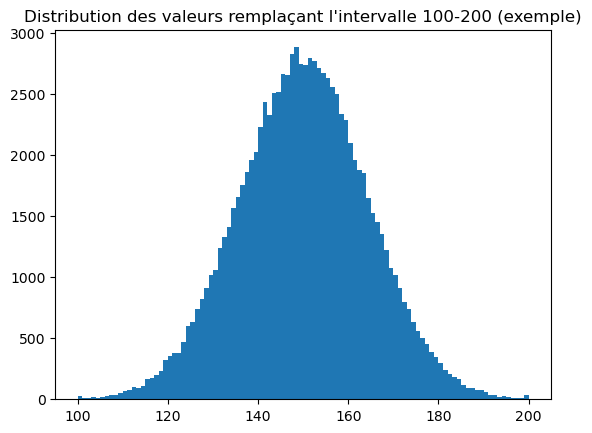

In [304]:
def replace_interval(val):
    if '-' in str(val):
        bounds = val.split('-')
        lower_bound = float(bounds[0])
        upper_bound = float(bounds[1])
        to_ret = np.random.normal(loc=(lower_bound + upper_bound) / 2, scale=(upper_bound - lower_bound) / 7)
        if to_ret < lower_bound:
            to_ret = lower_bound
        if to_ret > upper_bound:
            to_ret = upper_bound
        return to_ret
    else:
        return float(val)
    
test =[replace_interval("100-200") for i in range(100000)]
plt.hist(test, bins=100)
plt.title("Distribution des valeurs remplaçant l'intervalle 100-200 (exemple)")
plt.show()

In [305]:
df_common.loc[:, "Interpass_temp"] = df_common["Interpass_temp"].apply(replace_interval).astype(float)
df_common["Interpass_temp"] = df_common["Interpass_temp"].astype(float)
df_common["Interpass_temp"].describe()

count    1652.00000
mean      204.25077
std        39.34143
min        20.00000
25%       200.00000
50%       200.00000
75%       200.00000
max       300.00000
Name: Interpass_temp, dtype: float64

### Gestion des colonnes AC_DC et Electrode_polarity 

In [306]:
df_common['AC_DC'].unique(), df_common['Electrode_polarity'].unique()

(array(['DC', 'AC', nan], dtype=object),
 array(['+', '0', '-', nan], dtype=object))

<Axes: >

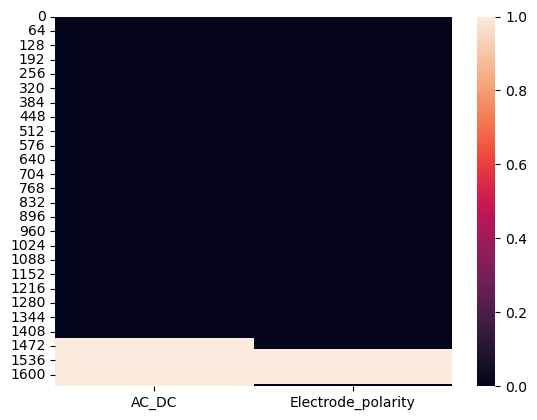

In [307]:
sns.heatmap(df_common[['AC_DC', 'Electrode_polarity']].isna())

In [308]:
df_common[['AC_DC', 'Electrode_polarity']].describe()

,AC_DC,Electrode_polarity
count,1437,1496
unique,2,3
top,DC,+
freq,1395,1451


Les colonnes sont quasiment constantes : DC apparaît 97% du temps et + apparaît 96% du temps. 

On va tester un imputing avec des modèles robustes au problème de déséquilibre de classe (Arbres).

#### Imputing AC_DC 

In [309]:
# import Kfold, RandomForestClassifier, XGBoostClassifier, AdaBoostClassifier

from sklearn.model_selection import KFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix

# Pas besoin de scaler les données pour les modèles d'arbres

full = df_common[list(set(df_common.columns) - set(['Electrode_polarity']))].copy()
full.dropna(inplace=True)

cols = list(set(full.columns) - set(['AC_DC', 'Electrode_polarity', 'Current', 'Voltage'])) # On enlève Current et Voltage car nan

X = full[cols]
y = full['AC_DC']

In [310]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model = AdaBoostClassifier(n_estimators=100, random_state=42, algorithm='SAMME')
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    print((model.predict(X_test) == y_test).sum(), "predictions correctes sur", len(y_test))
    print(f"Fold accuracy: {score:.2%}")
    # matric confusionn
    print(confusion_matrix(y_test, model.predict(X_test)))

267 predictions correctes sur 267
Fold accuracy: 100.00%
[[  8   0]
 [  0 259]]
267 predictions correctes sur 267
Fold accuracy: 100.00%
[[  9   0]
 [  0 258]]
267 predictions correctes sur 267
Fold accuracy: 100.00%
[[  9   0]
 [  0 258]]
266 predictions correctes sur 266
Fold accuracy: 100.00%
[[  4   0]
 [  0 262]]
266 predictions correctes sur 266
Fold accuracy: 100.00%
[[  4   0]
 [  0 262]]
266 predictions correctes sur 266
Fold accuracy: 100.00%
[[ 11   0]
 [  0 255]]
266 predictions correctes sur 266
Fold accuracy: 100.00%
[[ 11   0]
 [  0 255]]
266 predictions correctes sur 266
Fold accuracy: 100.00%
[[ 10   0]
 [  0 256]]
266 predictions correctes sur 266
Fold accuracy: 100.00%
[[ 10   0]
 [  0 256]]


On a de très bons résultats avec le AdaBoostClassifier, on peut facilement remplacer les valeurs manquantes. 

Résultat peut être trop bon --> voir s'il n'y a pas une merde mais ça a l'air ok

In [311]:
# Imputing AC_DC
model.fit(X, y)
df_common.loc[df_common['AC_DC'].isna(), 'AC_DC'] = model.predict(df_common.loc[df_common['AC_DC'].isna(), cols])

#### Imputing Electrode_polarity

In [312]:
full = df_common[list(set(df_common.columns) - set(['AC_DC']))].copy()
full.dropna(inplace=True)

cols = list(set(full.columns) - set(['AC_DC', 'Electrode_polarity', 'Current', 'Voltage'])) # On enlève Current et Voltage car nan

X = full[cols]
y = full['Electrode_polarity']

In [313]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model = AdaBoostClassifier(n_estimators=100, random_state=42, algorithm='SAMME')
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    print((model.predict(X_test) == y_test).sum(), "predictions correctes sur", len(y_test))
    print(f"Fold accuracy: {score:.2%}")
    # matric confusionn
    print(confusion_matrix(y_test, model.predict(X_test)))

278 predictions correctes sur 279
Fold accuracy: 99.64%
[[268   0   0]
 [  0   1   0]
 [  1   0   9]]
278 predictions correctes sur 278
Fold accuracy: 100.00%
[[270   0   0]
 [  0   3   0]
 [  0   0   5]]
278 predictions correctes sur 278
Fold accuracy: 100.00%
[[270   0   0]
 [  0   3   0]
 [  0   0   5]]
276 predictions correctes sur 278
Fold accuracy: 99.28%
[[269   0   0]
 [  2   0   0]
 [  0   0   7]]
276 predictions correctes sur 278
Fold accuracy: 99.28%
[[269   0   0]
 [  2   0   0]
 [  0   0   7]]
278 predictions correctes sur 278
Fold accuracy: 100.00%
[[268   0   0]
 [  0   1   0]
 [  0   0   9]]
278 predictions correctes sur 278
Fold accuracy: 100.00%
[[268   0   0]
 [  0   1   0]
 [  0   0   9]]
278 predictions correctes sur 278
Fold accuracy: 100.00%
[[271   0]
 [  0   7]]
278 predictions correctes sur 278
Fold accuracy: 100.00%
[[271   0]
 [  0   7]]


Ici aussi les résultats ont l'air très bon. Les modèles n'ignorent pas une des classe. On peut l'utiliser.

In [314]:
# Imputing Electrode_polarity
model.fit(X, y)
df_common.loc[df_common['Electrode_polarity'].isna(), 'Electrode_polarity'] = model.predict(df_common.loc[df_common['Electrode_polarity'].isna(), cols])

In [315]:
# AC_DC est catégorielle, on fait du one-hot encoding
df_common = pd.get_dummies(df_common, columns=['AC_DC'], prefix='AC_DC', drop_first=False, dtype=int)

# Electrode_polarity est catégorielle, on fait du one-hot encoding
df_common = pd.get_dummies(df_common, columns=['Electrode_polarity'], prefix='Electrode_polarity', drop_first=False, dtype=int)

#### Gestion des nan dans les colonnes numériques

In [316]:
df_common.isna().sum()

C                         0
Si                        0
Mn                        0
S                         0
P                         0
Ni                        0
Cr                        0
Mo                        0
V                         0
Cu                        0
Co                        0
W                         0
O                         0
Ti                        0
N                         0
Al                        0
B                         0
Nb                        0
Sn                        0
As                        0
Sb                        0
Current                 248
Voltage                 248
Heat_input                0
Interpass_temp            0
PWHT_temp                13
PWHT_time                13
Weld_type_FCA             0
Weld_type_GMAA            0
Weld_type_GTAA            0
Weld_type_MMA             0
Weld_type_NGGMA           0
Weld_type_NGSAW           0
Weld_type_SA              0
Weld_type_SAA             0
Weld_type_ShMA      

In [317]:
cols_na = ['Current', 'Voltage', 'PWHT_temp', 'PWHT_time']

df_common[cols_na].describe()

,Current,Voltage,PWHT_temp,PWHT_time
count,1404.000000,1404.000000,1639.000000,1639.000000
mean,283.843661,27.607379,304.674192,5.049652
std,192.560955,12.555629,285.498003,6.096034
min,115.000000,11.500000,0.000000,0.000000
25%,170.000000,21.000000,0.000000,0.000000
50%,170.000000,21.000000,250.000000,2.000000
75%,300.000000,30.000000,580.000000,10.000000
max,900.000000,75.360000,760.000000,24.000000


In [318]:
df_common[cols_na]

,Current,Voltage,PWHT_temp,PWHT_time
0,170.0,21.0,250.0,14.0
1,170.0,21.0,0.0,0.0
2,170.0,21.0,580.0,2.0
3,170.0,21.0,250.0,14.0
4,170.0,21.0,0.0,0.0
...,...,...,...,...
1647,450.0,30.0,760.0,2.0
1648,450.0,30.0,760.0,2.0
1649,450.0,30.0,760.0,2.0
1650,450.0,30.0,760.0,2.0


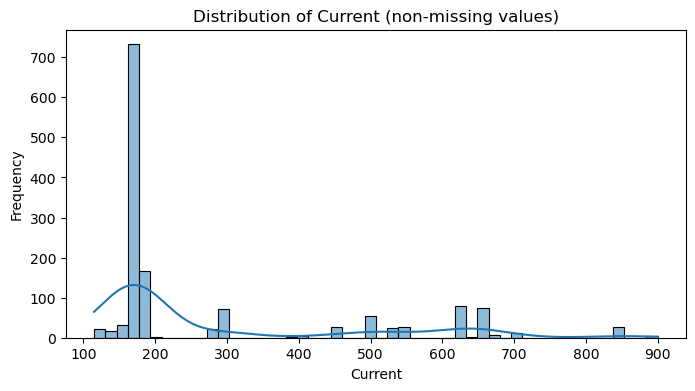

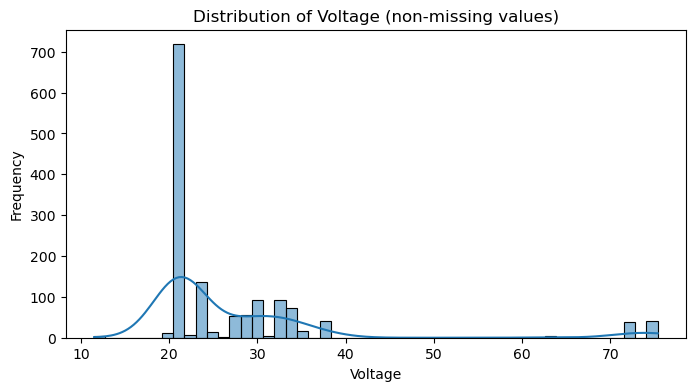

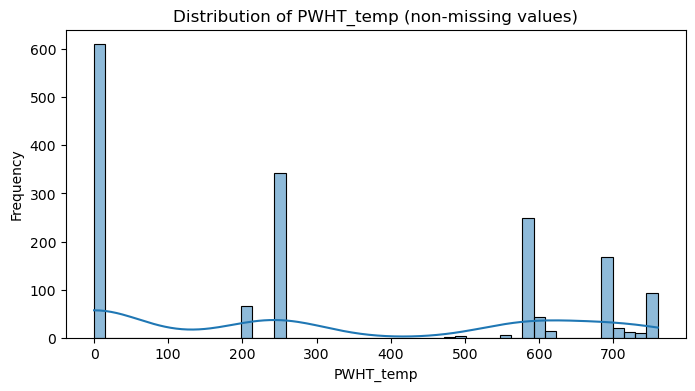

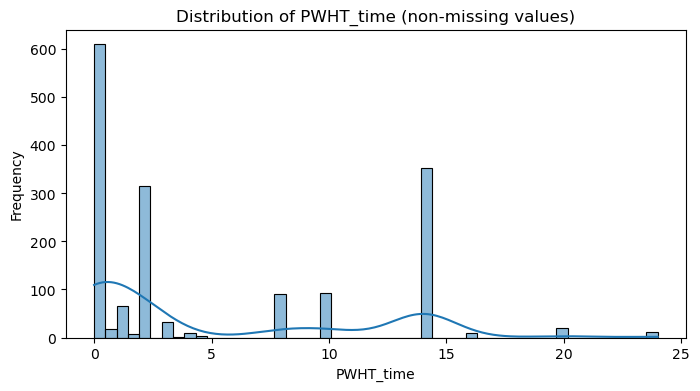

In [319]:
# Plot of the distributions of the columns with missing values
for col in cols_na:
    plt.figure(figsize=(8,4))
    sns.histplot(df_common[col].dropna(), bins=50, kde=True)
    plt.title(f'Distribution of {col} (non-missing values)')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

Les distributions sont très disparates. On va essayer de remplacer les valeurs manquantes avec les mêmes méthodes que précédemment.

In [320]:
from sklearn.ensemble import AdaBoostRegressor

models = {}

for col in cols_na:
    full = df_common[list(set(df_common.columns) - (set(cols_na) - {col}))].copy()
    full.dropna(inplace=True)

    cols = list(set(full.columns) - set(cols_na)) 

    X = full[cols]
    y = full[col]

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    model = AdaBoostRegressor(n_estimators=100, random_state=42)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        #score = model.score(X_test, y_test)
        score = np.sqrt(np.mean((model.predict(X_test) - y_test) ** 2))
        print(f"Fold RMSE for {col}: {score}")
        print(f"Fold R2 for {col}: {model.score(X_test, y_test):.2%}\n")
    
    print("_"*40+"\n")
    model.fit(X, y)
    models[col] = (model, cols)

Fold RMSE for Current: 22.921064587869306
Fold R2 for Current: 98.63%

Fold RMSE for Current: 21.61310084162466
Fold R2 for Current: 98.75%

Fold RMSE for Current: 21.61310084162466
Fold R2 for Current: 98.75%

Fold RMSE for Current: 18.177643300885034
Fold R2 for Current: 99.15%

Fold RMSE for Current: 18.177643300885034
Fold R2 for Current: 99.15%

Fold RMSE for Current: 20.800782485623788
Fold R2 for Current: 98.80%

Fold RMSE for Current: 20.800782485623788
Fold R2 for Current: 98.80%

Fold RMSE for Current: 20.684988342388934
Fold R2 for Current: 98.76%

________________________________________

Fold RMSE for Current: 20.684988342388934
Fold R2 for Current: 98.76%

________________________________________

Fold RMSE for Voltage: 1.966767765989033
Fold R2 for Voltage: 97.72%

Fold RMSE for Voltage: 3.214252935126583
Fold R2 for Voltage: 94.03%

Fold RMSE for Voltage: 1.9444333885137461
Fold R2 for Voltage: 97.58%

Fold RMSE for Voltage: 1.966767765989033
Fold R2 for Voltage: 97.72%

Pour les variables Current et Voltage, le modèle est performant donc on va pouvoir compléter les valeurs manquantes. Pour les colonnes PWHT_temp et PWHT_time les résultats sont bien moins bon et les résultats varient beaucoup d'un plie à l'autre, montrant une grande variance dans les résultats. Etant donné qu'il n'y a que peu de valeurs manquantes (13) on va tout de même les compléter avec le modèle mais ces variables pourraient ne pas être utilisées à l'avenir. 

In [321]:
# Imputing des colonnes avec les modèles entrainés
for col in cols_na:
    df_common.loc[df_common[col].isna(), col] = models[col][0].predict(df_common.loc[df_common[col].isna(), models[col][1]])

In [322]:
df_common.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 42 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   C                     1652 non-null   float64
 1   Si                    1652 non-null   float64
 2   Mn                    1652 non-null   float64
 3   S                     1652 non-null   float64
 4   P                     1652 non-null   float64
 5   Ni                    1652 non-null   float64
 6   Cr                    1652 non-null   float64
 7   Mo                    1652 non-null   float64
 8   V                     1652 non-null   float64
 9   Cu                    1652 non-null   float64
 10  Co                    1652 non-null   float64
 11  W                     1652 non-null   float64
 12  O                     1652 non-null   float64
 13  Ti                    1652 non-null   float64
 14  N                     1652 non-null   float64
 15  Al                   

On a maintenant uniquement des valeurs numériques et plus aucun nan dans les colonnes communes au 2 datasets. On va pouvoir commencer à faire l'analyse des colonnes spécifiques. 

# Gestion du dataset 1

In [ ]:
first_dataset_cols # colonnes spécifiques au premier dataset

['Yield_strength', 'UTS', 'Elongation', 'Reduction_area']

In [46]:
df1 = pd.concat([df_common, df_first[first_dataset_cols]], axis=1)
df1

,C,Si,Mn,S,P,Ni,Cr,Mo,V,Cu,...,Weld_type_TSA,AC_DC_AC,AC_DC_DC,Electrode_polarity_+,Electrode_polarity_-,Electrode_polarity_0,Yield_strength,UTS,Elongation,Reduction_area
0,0.037,0.30,0.65,0.008,0.012,0.00,0.0,0.00,0.00,0.0,...,0,0,1,1,0,0,392.0,466.0,31.9,80.6
1,0.037,0.30,0.65,0.008,0.012,0.00,0.0,0.00,0.00,0.0,...,0,0,1,1,0,0,NaN,NaN,NaN,NaN
2,0.037,0.30,0.65,0.008,0.012,0.00,0.0,0.00,0.00,0.0,...,0,0,1,1,0,0,370.0,456.0,35.2,80.6
3,0.037,0.31,1.03,0.007,0.014,0.00,0.0,0.00,0.00,0.0,...,0,0,1,1,0,0,413.0,498.0,31.2,80.6
4,0.037,0.31,1.03,0.007,0.014,0.00,0.0,0.00,0.00,0.0,...,0,0,1,1,0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647,0.100,0.35,0.90,0.008,0.016,0.60,8.6,0.98,0.18,0.0,...,0,0,1,1,0,0,834.0,NaN,NaN,NaN
1648,0.088,0.36,0.88,0.008,0.017,0.57,8.4,0.94,0.19,0.0,...,0,0,1,1,0,0,822.0,NaN,NaN,NaN
1649,0.090,0.34,0.89,0.008,0.016,0.17,8.2,0.94,0.02,0.0,...,0,0,1,1,0,0,660.0,NaN,NaN,NaN
1650,0.092,0.35,0.90,0.008,0.016,0.54,8.4,0.97,0.17,0.0,...,0,0,1,1,0,0,832.0,NaN,NaN,NaN


In [47]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 46 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   C                     1652 non-null   float64
 1   Si                    1652 non-null   float64
 2   Mn                    1652 non-null   float64
 3   S                     1652 non-null   float64
 4   P                     1652 non-null   float64
 5   Ni                    1652 non-null   float64
 6   Cr                    1652 non-null   float64
 7   Mo                    1652 non-null   float64
 8   V                     1652 non-null   float64
 9   Cu                    1652 non-null   float64
 10  Co                    1652 non-null   float64
 11  W                     1652 non-null   float64
 12  O                     1652 non-null   float64
 13  Ti                    1652 non-null   float64
 14  N                     1652 non-null   float64
 15  Al                   

In [ ]:
# TODO : faire toute l'analyse

# Gestion du dataset 2 

In [323]:
second_dataset_cols # colonnes spécifiques au second dataset

['Charpy_temp', 'Charpy_impact']

In [324]:
df2 = pd.concat([df_common, df_second[second_dataset_cols]], axis=1)
df2

,C,Si,Mn,S,P,Ni,Cr,Mo,V,Cu,...,Weld_type_SAA,Weld_type_ShMA,Weld_type_TSA,AC_DC_AC,AC_DC_DC,Electrode_polarity_+,Electrode_polarity_-,Electrode_polarity_0,Charpy_temp,Charpy_impact
0,0.037,0.30,0.65,0.008,0.012,0.00,0.0,0.00,0.00,0.0,...,0,0,0,0,1,1,0,0,NaN,NaN
1,0.037,0.30,0.65,0.008,0.012,0.00,0.0,0.00,0.00,0.0,...,0,0,0,0,1,1,0,0,-28.0,100.0
2,0.037,0.30,0.65,0.008,0.012,0.00,0.0,0.00,0.00,0.0,...,0,0,0,0,1,1,0,0,-38.0,100.0
3,0.037,0.31,1.03,0.007,0.014,0.00,0.0,0.00,0.00,0.0,...,0,0,0,0,1,1,0,0,NaN,NaN
4,0.037,0.31,1.03,0.007,0.014,0.00,0.0,0.00,0.00,0.0,...,0,0,0,0,1,1,0,0,-48.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647,0.100,0.35,0.90,0.008,0.016,0.60,8.6,0.98,0.18,0.0,...,0,0,0,0,1,1,0,0,NaN,NaN
1648,0.088,0.36,0.88,0.008,0.017,0.57,8.4,0.94,0.19,0.0,...,0,0,0,0,1,1,0,0,NaN,NaN
1649,0.090,0.34,0.89,0.008,0.016,0.17,8.2,0.94,0.02,0.0,...,0,0,0,0,1,1,0,0,NaN,NaN
1650,0.092,0.35,0.90,0.008,0.016,0.54,8.4,0.97,0.17,0.0,...,0,0,0,0,1,1,0,0,NaN,NaN


In [325]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 44 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   C                     1652 non-null   float64
 1   Si                    1652 non-null   float64
 2   Mn                    1652 non-null   float64
 3   S                     1652 non-null   float64
 4   P                     1652 non-null   float64
 5   Ni                    1652 non-null   float64
 6   Cr                    1652 non-null   float64
 7   Mo                    1652 non-null   float64
 8   V                     1652 non-null   float64
 9   Cu                    1652 non-null   float64
 10  Co                    1652 non-null   float64
 11  W                     1652 non-null   float64
 12  O                     1652 non-null   float64
 13  Ti                    1652 non-null   float64
 14  N                     1652 non-null   float64
 15  Al                   


Valeurs manquantes par colonne:
Charpy_temp      773
Charpy_impact    773
dtype: int64

Proportions manquantes:
Charpy_temp      46.79
Charpy_impact    46.79
dtype: float64


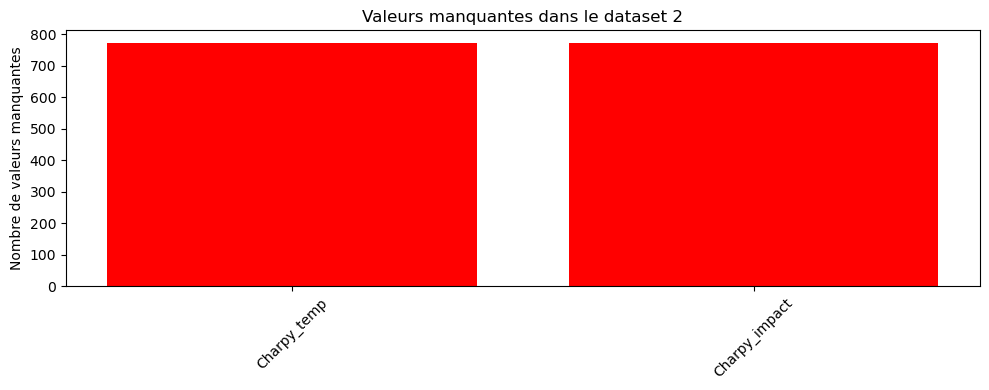

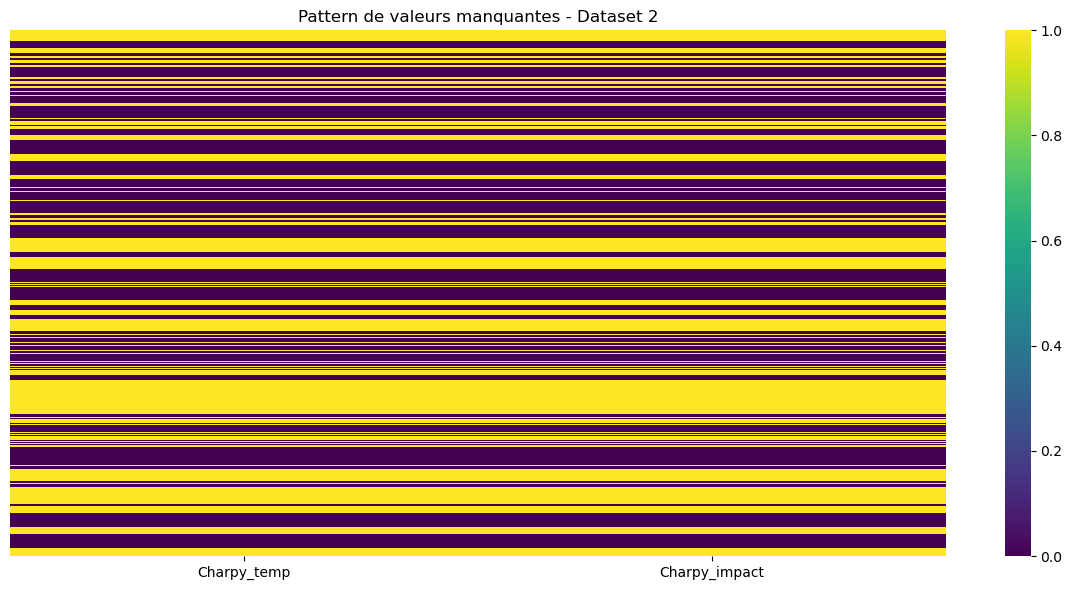


Statistiques des colonnes du dataset 2:
       Charpy_temp  Charpy_impact
count   879.000000      879.00000
mean    -34.606371       87.68942
std      34.738624       50.11670
min    -114.000000        3.00000
25%     -60.000000       38.00000
50%     -40.000000      100.00000
75%     -17.500000      100.00000
max     188.000000      270.00000


In [326]:
print(f"\nValeurs manquantes par colonne:")
print(df2[second_dataset_cols].isna().sum())
print(f"\nProportions manquantes:")
print((df2[second_dataset_cols].isna().sum() / len(df2) * 100).round(2))

# Visualisation des valeurs manquantes
fig, ax = plt.subplots(figsize=(10, 4))
missing_counts = df2[second_dataset_cols].isna().sum()
ax.bar(missing_counts.index, missing_counts.values, color=['red'])
ax.set_ylabel('Nombre de valeurs manquantes')
ax.set_title('Valeurs manquantes dans le dataset 2')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualisation du pattern de données manquantes
plt.figure(figsize=(12, 6))
sns.heatmap(df2[second_dataset_cols].isna(), cbar=True, cmap='viridis', yticklabels=False)
plt.title('Pattern de valeurs manquantes - Dataset 2')
plt.tight_layout()
plt.show()

# Statistiques descriptives des colonnes avec données non-manquantes
print(f"\nStatistiques des colonnes du dataset 2:")
print(df2[second_dataset_cols].describe())

On remarque que la température est en Celcius, pour éviter des problèmes liés au signe de la température on transforme ces températures en Kelvin (K) on va le faire à toutes les colonnes de températures
On remarque aussi que quand charpy impact est présent charpy temp aussi ce qui va simplifier notre imputation

In [327]:
# Identifier toutes les colonnes de température
temp_columns_in_df2 = [col for col in df2.columns if 'temp' in col.lower()]
print(f"\nColonnes de température détectées: {temp_columns_in_df2}")

for temp_col in temp_columns_in_df2:
    if temp_col in df2.columns:
        n_before = df2[temp_col].isna().sum()
        
        # Conversion seulement pour les valeurs non-manquantes
        mask = df2[temp_col].notna()
        df2.loc[mask, temp_col] = df2.loc[mask, temp_col] + 273.15
        
        n_after = df2[temp_col].isna().sum()
        
        print(f"\n{temp_col}:")
        print(f"Valeurs converties: {mask.sum()}")
        print(f"Nouvelles statistiques:")
        print(df2[temp_col].describe())




Colonnes de température détectées: ['Interpass_temp', 'PWHT_temp', 'Charpy_temp']

Interpass_temp:
Valeurs converties: 1652
Nouvelles statistiques:
count    1652.00000
mean      477.40077
std        39.34143
min       293.15000
25%       473.15000
50%       473.15000
75%       473.15000
max       573.15000
Name: Interpass_temp, dtype: float64

PWHT_temp:
Valeurs converties: 1652
Nouvelles statistiques:
count    1652.000000
mean      576.829218
std       284.783711
min       273.150000
25%       273.150000
50%       523.150000
75%       853.150000
max      1033.150000
Name: PWHT_temp, dtype: float64

Charpy_temp:
Valeurs converties: 879
Nouvelles statistiques:
count    879.000000
mean     238.543629
std       34.738624
min      159.150000
25%      213.150000
50%      233.150000
75%      255.650000
max      461.150000
Name: Charpy_temp, dtype: float64


On va passer à l'imputation toujours par adaboost mais on sauvegarde avant l'imputation pour pouvoir comparer ensuite

In [328]:
# Sauvegarder les distributions AVANT imputation
distributions_before = {}
for col in second_dataset_cols:
    distributions_before[col] = df2[col].dropna().copy()

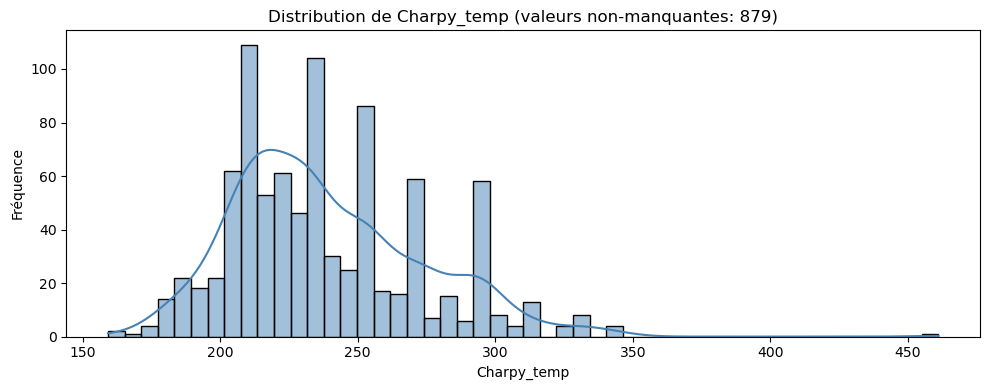

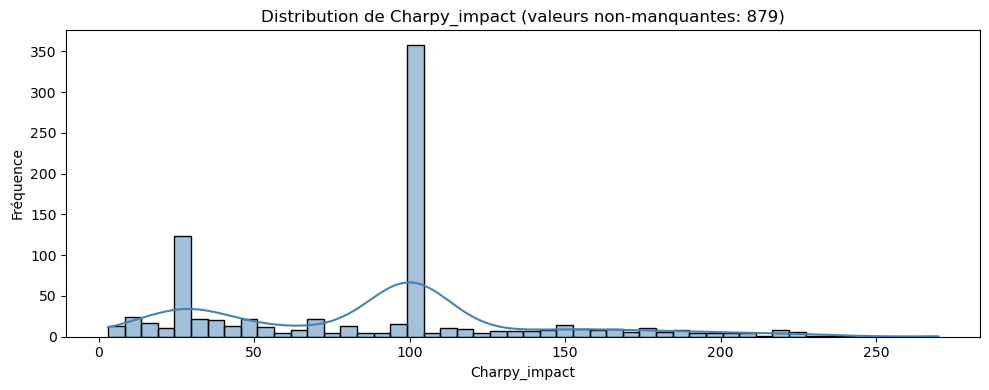

Fold RMSE for Charpy_temp: 26.794663334243822
Fold R2 for Charpy_temp: 28.30%

Fold RMSE for Charpy_temp: 31.996646325564008
Fold R2 for Charpy_temp: 14.60%

Fold RMSE for Charpy_temp: 33.85127798326301
Fold R2 for Charpy_temp: 2.46%

Fold RMSE for Charpy_temp: 28.168660567401094
Fold R2 for Charpy_temp: 37.17%

Fold RMSE for Charpy_temp: 30.04309261343636
Fold R2 for Charpy_temp: 32.66%

________________________________________

Fold RMSE for Charpy_impact: 47.84379032090788
Fold R2 for Charpy_impact: 17.71%

Fold RMSE for Charpy_impact: 44.918561140119955
Fold R2 for Charpy_impact: 4.86%

Fold RMSE for Charpy_impact: 48.16202558489439
Fold R2 for Charpy_impact: 19.98%

Fold RMSE for Charpy_impact: 42.878521823082906
Fold R2 for Charpy_impact: 16.66%

Fold RMSE for Charpy_impact: 43.894158032865356
Fold R2 for Charpy_impact: 22.21%

________________________________________

Charpy_temp: 773 valeurs imputées
Charpy_impact: 773 valeurs imputées

Vérification - Valeurs manquantes restant

In [329]:
for col in second_dataset_cols:
    if df2[col].notna().sum() > 0:
        plt.figure(figsize=(10, 4))
        sns.histplot(df2[col].dropna(), bins=50, kde=True, color='steelblue')
        plt.title(f'Distribution de {col} (valeurs non-manquantes: {df2[col].notna().sum()})')
        plt.xlabel(col)
        plt.ylabel('Fréquence')
        plt.tight_layout()
        plt.show()

## Imputation des colonnes du dataset 2 avec Adaboost

from sklearn.ensemble import AdaBoostRegressor

df2_full = df2.copy()

imputation_models = {}

for col in second_dataset_cols:
    full = df2_full[list(set(df2_full.columns) - (set(second_dataset_cols) - {col}))].copy()
    full.dropna(inplace=True)

    cols = list(set(full.columns) - set(second_dataset_cols)) 

    X = full[cols]
    y = full[col]

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    model = AdaBoostRegressor(n_estimators=100, random_state=42)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        #score = model.score(X_test, y_test)
        score = np.sqrt(np.mean((model.predict(X_test) - y_test) ** 2))
        print(f"Fold RMSE for {col}: {score}")
        print(f"Fold R2 for {col}: {model.score(X_test, y_test):.2%}\n")
    
    print("_"*40+"\n")
    model.fit(X, y)
    models[col] = (model, cols)


# Application de l'imputation pour les valeurs manquantes
for col in second_dataset_cols:
    if col in models:
        n_missing = df2[col].isna().sum()
        if n_missing > 0:
            model, feature_cols = models[col]
            indices_missing = df2.index[df2[col].isna()]
            
            X_missing = df2_full.loc[indices_missing, feature_cols]
            predictions = model.predict(X_missing)
            
            df2.loc[indices_missing, col] = predictions
            
            print(f"{col}: {n_missing} valeurs imputées")
        else:
            print(f"{col}: aucune valeur manquante")
    else:
        print(f"{col}: imputation non disponible (données insuffisantes)")

# Vérification finale
print(f"\nVérification - Valeurs manquantes restantes:")
print(df2[second_dataset_cols].isna().sum())

# Statistiques finales après imputation
print(f"\nStatistiques du dataset 2 après imputation:")
print(df2[second_dataset_cols].describe())

Comparons les données avant et après l'imputation

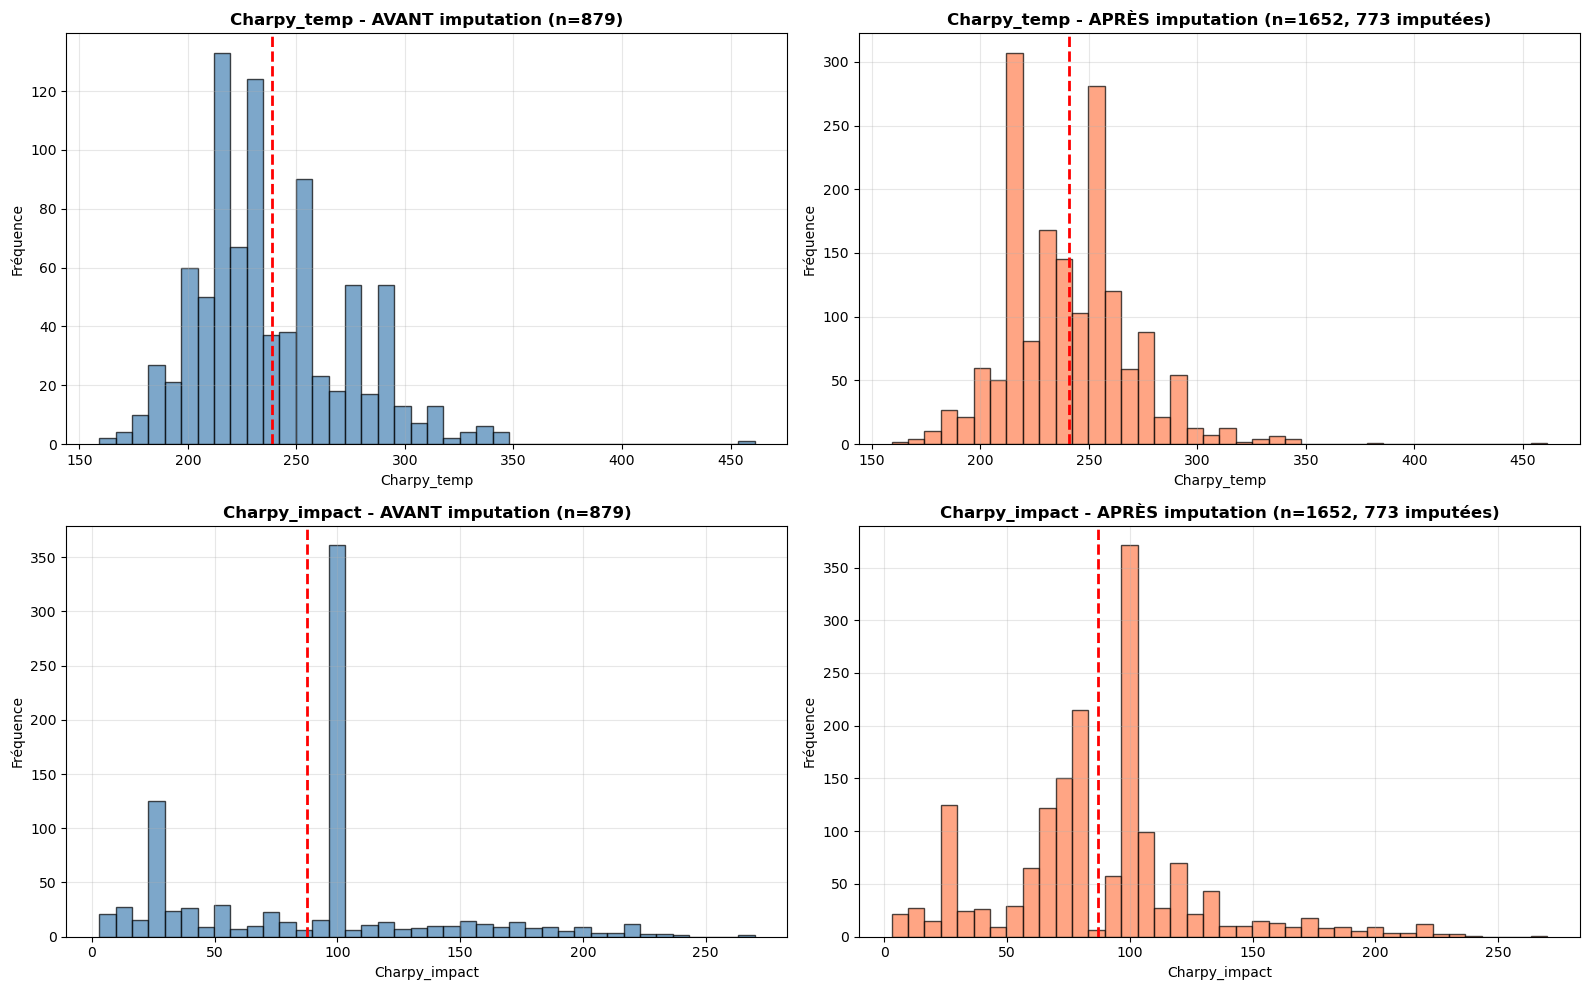


Charpy_temp:
  AVANT: n=879, mean=238.5436, std=34.7386
  APRÈS: n=1652, mean=241.0613, std=29.0041
  Changements: Δmean=+2.5177, Δstd=-5.7345

Charpy_impact:
  AVANT: n=879, mean=87.6894, std=50.1167
  APRÈS: n=1652, mean=87.0138, std=39.6109
  Changements: Δmean=-0.6756, Δstd=-10.5058


In [331]:
# Comparaison AVANT/APRÈS imputation
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for idx, col in enumerate(second_dataset_cols):
    ax_before = axes[idx, 0]
    ax_before.hist(distributions_before[col], bins=40, alpha=0.7, color='steelblue', edgecolor='black')
    ax_before.set_title(f'{col} - AVANT imputation (n={len(distributions_before[col])})', fontweight='bold')
    ax_before.set_xlabel(col)
    ax_before.set_ylabel('Fréquence')
    ax_before.grid(True, alpha=0.3)
    ax_before.axvline(distributions_before[col].mean(), color='red', linestyle='--', linewidth=2)
    
    ax_after = axes[idx, 1]
    ax_after.hist(df2[col], bins=40, alpha=0.7, color='coral', edgecolor='black')
    n_imputed = len(df2[col]) - len(distributions_before[col])
    ax_after.set_title(f'{col} - APRÈS imputation (n={len(df2[col])}, {n_imputed} imputées)', fontweight='bold')
    ax_after.set_xlabel(col)
    ax_after.set_ylabel('Fréquence')
    ax_after.grid(True, alpha=0.3)
    ax_after.axvline(df2[col].mean(), color='red', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()

for col in second_dataset_cols:
    print(f"\n{col}:")
    print(f"  AVANT: n={len(distributions_before[col])}, mean={distributions_before[col].mean():.4f}, std={distributions_before[col].std():.4f}")
    print(f"  APRÈS: n={len(df2[col])}, mean={df2[col].mean():.4f}, std={df2[col].std():.4f}")
    
    delta_mean = df2[col].mean() - distributions_before[col].mean()
    delta_std = df2[col].std() - distributions_before[col].std()
    print(f"  Changements: Δmean={delta_mean:+.4f}, Δstd={delta_std:+.4f}")


KNN Imputation
Valeurs manquantes après KNN: 0


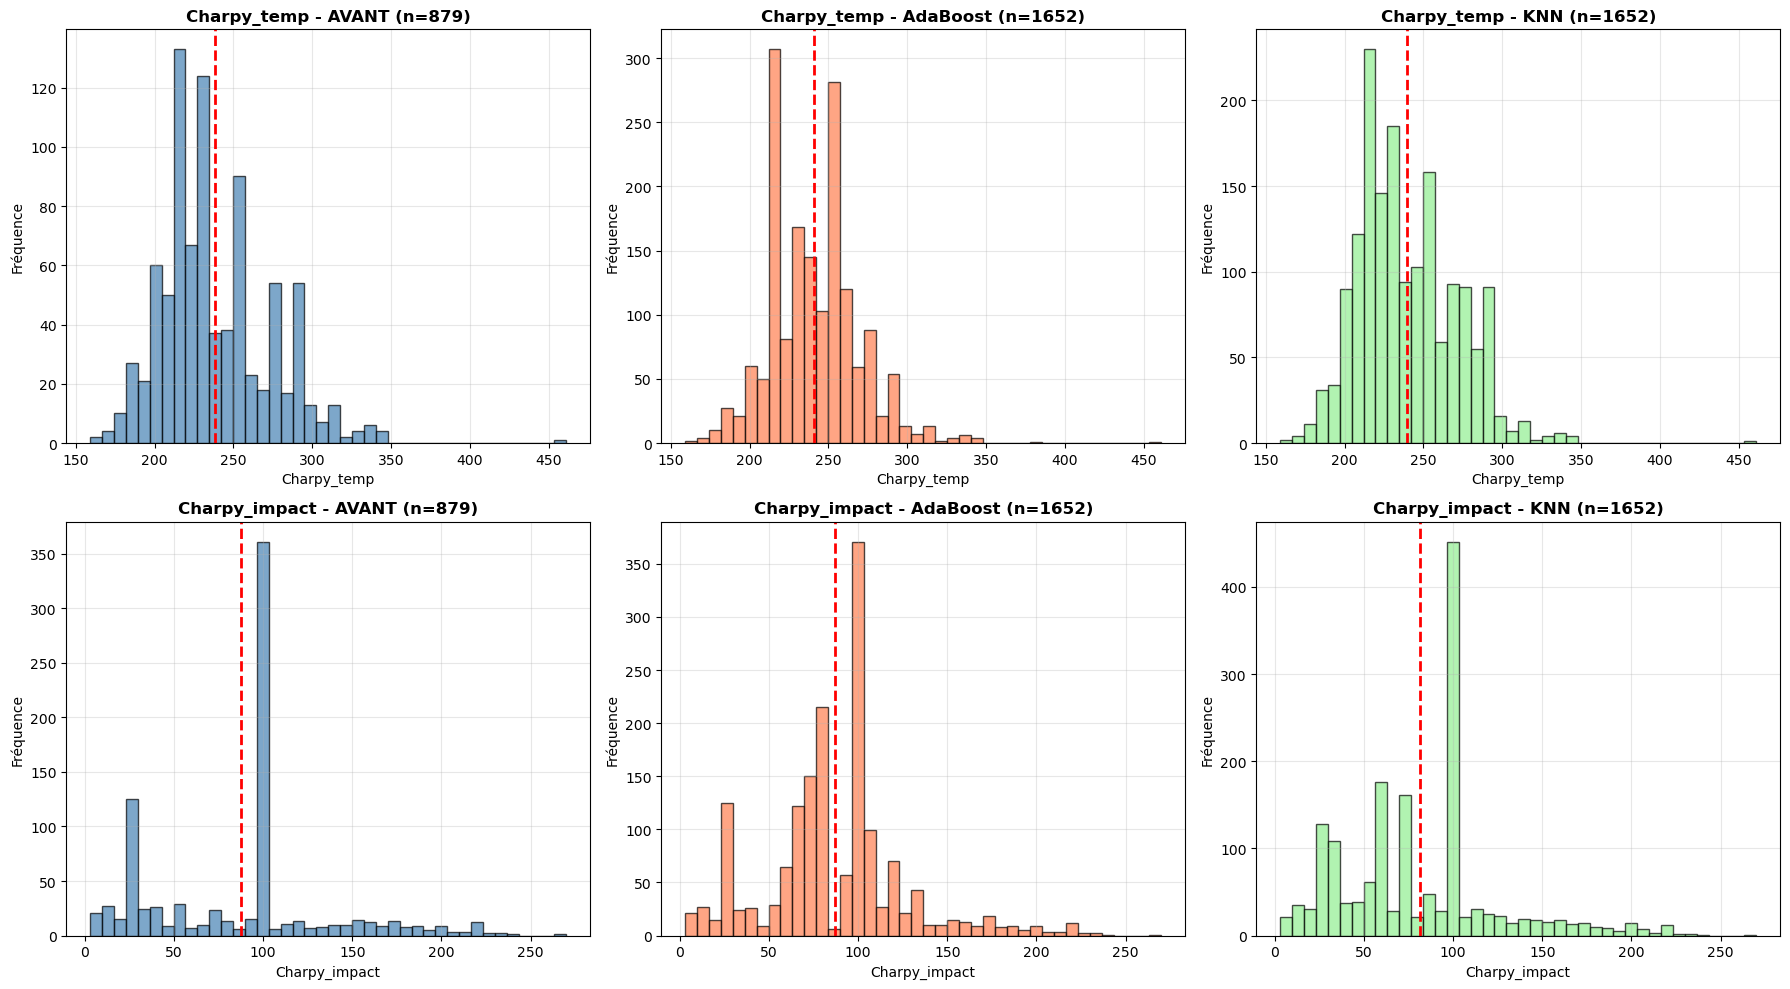


Comparaison détaillée:

Charpy_temp:
  AVANT:
    mean=238.5436, std=34.7386
  AdaBoost:
    mean=241.0613, std=29.0041
    Δmean=+2.5177, Δstd=-5.7345
  KNN:
    mean=239.5556, std=31.4450
    Δmean=+1.0119, Δstd=-3.2937

Charpy_impact:
  AVANT:
    mean=87.6894, std=50.1167
  AdaBoost:
    mean=87.0138, std=39.6109
    Δmean=-0.6756, Δstd=-10.5058
  KNN:
    mean=81.2961, std=43.8877
    Δmean=-6.3933, Δstd=-6.2290


In [ ]:
from sklearn.impute import KNNImputer

# Tester plusieurs valeurs de k pour KNN
print("KNN Imputation - Test de différentes valeurs de k")
print("="*60)

scaler = StandardScaler()
numeric_cols = df2_full.select_dtypes(include=[np.number]).columns

k_values = [3, 5, 7, 10]
knn_results = {}

for k in k_values:
    df2_knn_temp = df2_full.copy()
    df2_knn_scaled = df2_full.copy()
    df2_knn_scaled[numeric_cols] = scaler.fit_transform(df2_full[numeric_cols])
    
    imputer_knn = KNNImputer(n_neighbors=k)
    df2_knn_scaled[numeric_cols] = imputer_knn.fit_transform(df2_knn_scaled[numeric_cols])
    df2_knn_temp[numeric_cols] = scaler.inverse_transform(df2_knn_scaled[numeric_cols])
    
    knn_results[k] = df2_knn_temp
    print(f"KNN (k={k}) - Valeurs manquantes restantes: {df2_knn_temp[second_dataset_cols].isna().sum().sum()}")

# Visualisation comparative: AVANT, AdaBoost, KNN(k=3,5,7,10)
fig, axes = plt.subplots(2, 6, figsize=(24, 10))

for idx, col in enumerate(second_dataset_cols):
    # AVANT
    axes[idx, 0].hist(distributions_before[col], bins=40, alpha=0.7, color='steelblue', edgecolor='black')
    axes[idx, 0].set_title(f'{col} - AVANT', fontweight='bold', fontsize=10)
    axes[idx, 0].set_xlabel(col, fontsize=8)
    axes[idx, 0].set_ylabel('Fréquence', fontsize=8)
    axes[idx, 0].grid(True, alpha=0.3)
    axes[idx, 0].axvline(distributions_before[col].mean(), color='red', linestyle='--', linewidth=2)
    axes[idx, 0].tick_params(labelsize=8)
    
    # AdaBoost
    axes[idx, 1].hist(df2[col], bins=40, alpha=0.7, color='coral', edgecolor='black')
    axes[idx, 1].set_title(f'{col} - AdaBoost', fontweight='bold', fontsize=10)
    axes[idx, 1].set_xlabel(col, fontsize=8)
    axes[idx, 1].set_ylabel('Fréquence', fontsize=8)
    axes[idx, 1].grid(True, alpha=0.3)
    axes[idx, 1].axvline(df2[col].mean(), color='red', linestyle='--', linewidth=2)
    axes[idx, 1].tick_params(labelsize=8)
    
    # KNN avec différents k
    for k_idx, k in enumerate(k_values):
        axes[idx, 2+k_idx].hist(knn_results[k][col], bins=40, alpha=0.7, color='lightgreen', edgecolor='black')
        axes[idx, 2+k_idx].set_title(f'{col} - KNN(k={k})', fontweight='bold', fontsize=10)
        axes[idx, 2+k_idx].set_xlabel(col, fontsize=8)
        axes[idx, 2+k_idx].set_ylabel('Fréquence', fontsize=8)
        axes[idx, 2+k_idx].grid(True, alpha=0.3)
        axes[idx, 2+k_idx].axvline(knn_results[k][col].mean(), color='red', linestyle='--', linewidth=2)
        axes[idx, 2+k_idx].tick_params(labelsize=8)

plt.tight_layout()
plt.show()

# Tableau comparatif détaillé
print("\nComparaison détaillée:")
for col in second_dataset_cols:
    print(f"\n{col}:")
    print(f"  AVANT:")
    print(f"    mean={distributions_before[col].mean():.4f}, std={distributions_before[col].std():.4f}")
    print(f"  AdaBoost:")
    ab_mean = df2[col].mean()
    ab_std = df2[col].std()
    print(f"    mean={ab_mean:.4f}, std={ab_std:.4f}")
    print(f"    Δmean={ab_mean - distributions_before[col].mean():+.4f}, Δstd={ab_std - distributions_before[col].std():+.4f}")
    
    for k in k_values:
        knn_mean = knn_results[k][col].mean()
        knn_std = knn_results[k][col].std()
        print(f"  KNN (k={k}):")
        print(f"    mean={knn_mean:.4f}, std={knn_std:.4f}")
        print(f"    Δmean={knn_mean - distributions_before[col].mean():+.4f}, Δstd={knn_std - distributions_before[col].std():+.4f}")

# Résumé des différences par rapport à AVANT
print("\n\nRésumé des écarts (Δmean et Δstd):")
print("-"*80)
for col in second_dataset_cols:
    print(f"\n{col}:")
    print(f"  {'Méthode':<15} {'Δmean':<15} {'Δstd':<15}")
    print(f"  {'-'*45}")
    
    ab_mean_diff = df2[col].mean() - distributions_before[col].mean()
    ab_std_diff = df2[col].std() - distributions_before[col].std()
    print(f"  {'AdaBoost':<15} {ab_mean_diff:+.4f}        {ab_std_diff:+.4f}")
    
    for k in k_values:
        knn_mean_diff = knn_results[k][col].mean() - distributions_before[col].mean()
        knn_std_diff = knn_results[k][col].std() - distributions_before[col].std()
        print(f"  {'KNN(k='+str(k)+')':<15} {knn_mean_diff:+.4f}        {knn_std_diff:+.4f}")


# Merge des data

In [ ]:
# TODO

# Trouver un label de qualité

PCA en 2D sur les colonnes qui peuvent se rapporter à la qualité pour faire une visualisation dans le même style que celle du cours avec la criminalité pour espérer avoir un label cohérent. 

In [ ]:
# TODO

# Fit des modèles sur le label créé 

Tester différents modèles avec preprocessing adéquat...

In [ ]:
# TODO